In [1]:
import numpy as np
import networkx as nx
from itertools import permutations
import time

I think that it could be useful mapping the Pauli strings into arrays in the following way
$$    I\mapsto 0, \hspace{1cm} X\mapsto 1, \hspace{1cm} Y\mapsto 2, \hspace{1cm} Z\mapsto 3. $$
Then, for example, $XIZY$ would be mapped to $[1,0,3,2]$. Similarly, we should map the measurements into numbers:
\begin{align*}
    TPBX&\mapsto 1& \hspace{1cm} Str_1=\{I, X\} = \{(0),(1)\}\\
    TPBY&\mapsto 2& \hspace{1cm} Str_2=\{I, Y\} = \{(0),(2)\}\\
    TPBZ&\mapsto 3& \hspace{1cm} Str_3=\{I, Z\} = \{(0),(3)\}\\
    Bell&\mapsto 4& \hspace{1cm} Str_4=\{II,XX,YY,ZZ\} = \{(0,0),(1,1),(2,2),(3,3)\}\\
    \Omega^X&\mapsto 5& \hspace{1cm}  Str_5=\{II,XX,YZ,ZY\} = \{(0,0),(1,1),(2,3),(3,2)\}\\
    \Omega^Y&\mapsto 6& \hspace{1cm}  Str_6=\{II,YY,XZ,ZX\} = \{(0,0),(2,2),(1,3),(3,1)\}\\
    \Omega^Z&\mapsto 7& \hspace{1cm}  Str_7=\{II,ZZ,XY,YX\} = \{(0,0),(3,3),(1,2),(2,1)\}\\
    \chi&\mapsto 8& \hspace{1cm}  Str_8=\{II,XY,YX,ZX\} = \{(0,0),(1,2),(2,1),(3,1)\}\\
    \Pi &\mapsto 9& \hspace{1cm}  Str_9=\{II,YX,ZY,XZ\} = \{(0,0),(2,1),(3,2),(1,3)\}\\
\end{align*}



Finally, we could builds strings of compatibility, one for each measurement. The string of compatibility of the measurement k should contain the vectors assigned to the Pauli strings that are compatible with the measurement k. For instance, if we consider the measure 4 (the Bell measure) its compatibility string should contain (0,0), (1,1), (2,2), (3,3), because the Bell measurement is compatible with $II,XX,YY\ \mathrm{and}\ ZZ.$


Thus, when checking the compatibility of the strings $v_i$ and $v_j$ with a measurement $k$ on the qubits $l,m$, what we should do is checking if $(v_i(l),v_i(m))$ and $(v_j(l),v_j(m))$ are both in the compatibility string of the measurement $k$. For example, if we had $v_i=YIZZ=[2,0,3,3]$ and $v_j=XIZY=[1,0,3,2]$ and wanted to check if theses strings are compatible with the measurement 0 (the Bell measurement) on the qubits (3,4), what we have to do is checking if $(v_i(3),v_i(4))=(3,3)$ and $(v_j(3),v_j(4))=(3,2)$ are in the compatibility string of the measurement 4. As this compatibility string is $Str_4=\{(0,0),(1,1),(2,2),(3,3)\}$, we have that $(v_i(3),v_i(4))$ belongs to $Str_4$ but $(v_j(3),v_j(4))$ does not. In consequence, the measurement 4 on the qubits (3,4) is not compatible with $v_i$ and $v_j$. 

# Pauli Graph construction with TPB basis, LDFC and TPBGrouping.  

In [2]:
def PauliGraph(PS):
    """
    Construction of the Pauli Graph
    
    Arguments:
    ----------
    PS           --A matrix of n rows (the number of Pauli strings of 
                   our problem) and N columns (size of the Puli string)
                   N == number o qubits.
                   a matrix with columns formed by different initial
                   states.
    Output:
    -------
    PG, the Pauli graph corresponding with the n Pauli strings given as input.
    """
    
    n=np.size(PS[:,0])
    N=np.size(PS[0,:])
    PG = nx.Graph()
    PG.add_nodes_from(np.arange(n))   #assigns a node to each Pauli string
    for i in range(n):               #run a loop over each Pauli string
        v_i=PS[i,:]
        
        for j in range(i+1,n):
            v_j=PS[j,:]
            qubits=np.arange(N)
            noncommonqubits=np.delete(qubits,np.argwhere(v_i==v_j)) #Delete the entries of 'qubits' that coincide. E.G. [...,X,...], [...,X,...]
            #rewrite the Pauli string only with letters that differ
            vi=v_i[noncommonqubits]
            vj=v_j[noncommonqubits]
            #if two Paulis are different they can still commute if one of them 
            # is the identity. For that, since I=0.
            if (vi*vj!=0).any():
                #With only one of the operators in the string not comuting we draw an edge between the two strings
                PG.add_edges_from([(i,j)])
    return PG

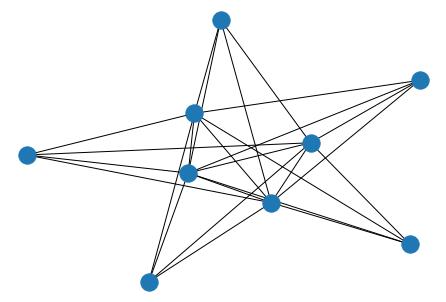

In [3]:
PS=np.array([[1,1,3],[2,2,3],[3,3,3],[3,3,3],[1,1,3],[1,2,3],[1,1,3],[1,1,3],[1,1,3] ])
nx.draw(PauliGraph(PS))

In [59]:
def LDFC(PG):
    """
    Largest Degree First Colouring, famous heuristic algorithm for colouring a graph
    
    Arguments:
    ----------
    PG           --The Pauli graph corresponding to the given Pauli strings
    
    Output:
    -------
    Color        --Array whose ith entry has the color assigned to the ith Pauli String.
    Groups       --List of lists. The ith list contains all the arrays assigned to the color i.
    """
    SV=sorted(PG.degree, key=lambda x: x[1], reverse=True)   #Sorted Vertices by decreasing degree
    n=PG.number_of_nodes()
    aux=list(np.arange(n))
    Color=n*np.ones(n)
    for i in range(n):
        IV=list(list(PG.neighbors(SV[i][0])))                #Vertices that are Incompatible with vertex SV[i][0]
        IC=Color[IV]                                         #Colors that are assigned to vertices that are incompatible with vertex SV[i]
        AC=[ elem for elem in aux if elem not in IC]         #Available colors for vertex SV[i]
        Color[SV[i][0]]=min(AC)
    MC=int(max(Color))
    Groups=[]
    for i in range(MC+1):
        Groups.append(list(np.argwhere(Color==i)))
    return Color, Groups

Grouping Based on how many Pauli strings can be measured only using local.

In [60]:
def TPBgrouping(PS): 
    """
    Largest Degree First Colouring, famous heuristic algorithm for colouring a graph
    
    Arguments:
    ----------
    PG           --The Pauli graph corresponding to the given Pauli strings
    
    Output:
    -------
    Color        --Array whose ith entry has the color assigned to the ith Pauli String.
    Groups       --List of lists. The ith list contains all the arrays assigned to the color i.
    Measurement  --List of measurements associated with each group.
    
    """
    PG=PauliGraph(PS)
    Color, Groups=LDFC(PG)
    N=np.size(PS[0,:])
    Measurements=[]        
    #The list of measurements. Each element will be the total measurement for a certain group. That measurement 
    #will be encoded as an N-array of {0,1,3,4}. 0 will appear in the position k if in the qubit k we can measure with any 
    #basis (will only happen if the k factor of every element of the group is I), 1 will appear in the position k if in the qubit k
    #we can measure with TPBX,...
    for i in range(len(Groups)):
        Mi=[]
        for k in range(N):
            Mi.append(max(PS[Groups[i],k]))
        Measurements.append(Mi)
    return Color, Groups, Measurements

## We implement the information about measurements manually.


We construct two lists with 9 elements each. The first one with all the available measurements sorted in the previos way, and the second specifying the length of the measure (number of qubits to measure)

In [61]:
Comp=[]
Comp.append([])#This empty list is just to fix notationComp.append([[0],[1]])
Comp.append([[0],[1]])
Comp.append([[0],[2]])
Comp.append([[0],[3]])
Comp.append([[0,0],[1,1],[2,2],[3,3]])
Comp.append([[0,0],[1,1],[2,3],[3,2]])
Comp.append([[0,0],[2,2],[1,3],[3,1]])
Comp.append([[0,0],[3,3],[1,2],[2,1]])
Comp.append([[0,0],[1,2],[2,3],[3,1]])
Comp.append([[0,0],[2,1],[3,2],[1,3]])
length=[]
length.append([])#This empty list is just to fix notation
length.append(1)
length.append(1)
length.append(1)
length.append(2)
length.append(2)
length.append(2)
length.append(2)
length.append(2)
length.append(2)

## Grouping code with non-local measurements 

In [1]:
def MeasurementAssignment(Vi,Vj,Mi,AM,WC):
    """
    Assigns a measurement to a given Pauli going throuh all the qubits in it.
    
    Arguments:
    ----------
    Vi           --Pauli string. ith row of the matrix PS
    Vj           --Pauli string. jth row of the matrix PS
    Mi           --list of measurements. Each measurement is encoded as list of two elements. The first one (Mi[0])
                 is the type of local measurement and the second (Mi[1]) are the qubits where the measurement acts. 
    AM           --Admisible Measurements. 
    WC           --Well Connected Qubits. 

    Output:
    -------
    PMi        --list of measurements. Example: Mi = {4,(1,2)}, Mi has the Bell measurement (nº4) as the 
               measurement acting on the qubits (1,2). PMi only contains entangled measurements. TPB are assigned later
    S          --Succes variable. If S==1, a measuremet has been succesfully assigned.
    
    """
    
    N=np.size(Vi)
    U=list(np.arange(N))
    S=0
    for LM in Mi:
        if list(Vj[LM[1]]) not in Comp[LM[0]]:  #check if any pair of qubits (LM[1]) is contained in Comp (the types of measurements introduced by hand).
            return Mi, S                        #no pair of qubits in Vj can be joined by a measuremente contained in Comp. NO SUCCES
        else:
            for s in LM[1]:                     #SUCCES. Remove the pair of qubits for which we have found a measurement
                U.remove(s)                     #and continue the process with a shorter chain. 
    
    commonfactors=np.argwhere(Vi==Vj)           #Check if any of the qubits not removed before are equal in both chains. If that is 
    for k in commonfactors:                     #the case remove as well. IDENTITIES AND TPB's DONT GET ASSIGNED WITH THIS FUNCTION.
        if k in U:
            U.remove(k)
    
    PMi=Mi[:]                 #I create a potential Mi.
    while len(U)!=0:          #In each succesful iteration the chain gets shortenned, untill if succesful len(U)=0.
        for Eps in AM:
            if len(U)>=length[Eps]:
                perm=list(permutations(U,length[Eps]))      #length of each local measurement is manually programmed
                perm=list({*map(tuple, map(sorted, perm))}) #This is a code for eliminating the permutations that
                            #are equal up to order for perm. This would reduce the iterations (I believe) without affecting the algorithm,
                            #because the WC array will contain all possible permutations, even those that are equal with disitinct order.
                            #and if the qubits (l,k) of Vi and Vj are compatible with a certain measurement, the qubits (k,l) of Vi and 
                            #Vj will be compatible with other measurement. 
                            
                for per in perm:
                    if (per in WC) or (length[Eps]==1):                                      #Checks if any simoultaneous permutation of qubits in Vi, Vj, can be
                        if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):#measured by AM, that is, it is in Comp. If this is the case, two 
                            PMi.append([Eps,list(per)])                                      #qubits get removed from the string and we continue the process.
                            for s in per:
                                U.remove(s)
                            break
                else:
                    continue
                break            #The string could not be shorttened completely. NOT SUCCES. Returns S=0.
        else:
            return Mi, S                                                                    
    S=1                           #The string could be shorttened completely(len(U)=0).SUCCES. Returns S=1.
    return PMi, S            

In [64]:
def grouping(PS, AM, WC): 
    """
    Founction that groups the different Pauli strings according to conmutativity. The posibility of 
    them being easured on the same basis depends on the allowed measurements and the conectivity 
    between qubits.
    
    Arguments:
    ----------
    PS           --Set of Pauli strings of our Hamiltonian.
    AM           --Admisible Measurements, the set of measures that can be performed. A vector with 
                 the measurements in the order of preferred assignment.
    WC           --Well Connected qubits. Qubits that can be entangled in a given processor.
    
    Output:
    -------
    Groups       --List of lists. The ith list contains all the arrays assigned to the color i.
    Measurements --List of measurements associated with each group.
    
    """
    
    PG=PauliGraph(PS)
    SV=sorted(PG.degree, key=lambda x: x[1], reverse=True)#Sorted Vertices by decreasing degree
    n=np.size(PS[:,0])      #number of strings 
    N=np.size(PS[0,:])      #number of qubits in string
    AS=[]                   #list of strings with assigned measurement
    Groups=[]               #list of groups
    Measurements=[]         #list of total measurements Mi
    for k in range(n):
        i=SV[k][0]
        if i not in AS:
            Mi=[]
            #Each local measurement will appear as a list of two elements. 
            #The first will correspond with the local measurement and the second
            # to the qubits. For example, if Mi contains {4,(1,2)} it would mean that Mi has the Bell measurement (nº4)
            #as the local measurement acting on the qubits (1,2)
            GroupMi=[i]
            AS.append(i)
            for l in range(n):
                j=SV[l][0]
                if j not in AS:
                    Mi, S = MeasurementAssignment(PS[i,:],PS[j,:],Mi,AM,WC)  #S is the success variable. If Mi is 
                                                                             #compatible with Vj S=1 otherwise S=0
                    if S==1:               #If we enter here succesful iterarion
                        AS.append(j)       #We add a measure to our list AS
                        GroupMi.append(j)  #We add the group associted with the measure
            
            QWM=list(np.arange(N))
            #Qubits Without a Measurement assigned by Mi. Measurement Assingment does not assign TPB measures
            #There, all factors of the group will be equal or 
            # the identity, so we will have to use a TPB measurement.
            for LM in Mi:
                for s in LM[1]:
                    QWM.remove(s)
            for q in QWM:
                TPBq=max(PS[GroupMi,q])
                Mi.append([TPBq,[q]])
            Groups.append(GroupMi)
            Measurements.append(Mi)
            
    return Groups, Measurements